#Import Libraries and mount the drive to access the drive

In [39]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, Reshape
from keras.utils import to_categorical
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers import Dropout, InputLayer, LSTM
from keras.layers import Bidirectional, BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout, UpSampling1D, AveragePooling1D

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')
os.chdir("./gdrive/MyDrive/Neural Competition Project")

In [41]:
pwd!

'/content/gdrive/My Drive/Neural Competition Project'

# Data Preprocessing before Feeding to Neural Network Model

The interpolated csv file is created by merging all the subject files with the y data interpolated to match the acc and gyrometer x sampling rate

In [ ]:
df=pd.read_csv('Interpolated_combined.csv')
walking = df[df.label==0].count()[0]
downstairs = df[df.label==1].count()[0]
upstairs = df[df.label==2].count()[0]
grass = df[df.label==3].count()[0]
print(walking, downstairs,upstairs, grass)

In [ ]:
# Partitioning the x and y data from the df.
# Dropping the time and label columns from the x dataframe 
y_train = df.label
x_train= df.drop('label', axis=1)
x_train= x_train.drop('time', axis=1)

In [5]:
print(y_train)

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1341612    0.0
1341613    0.0
1341614    0.0
1341615    0.0
1341616    0.0
Name: label, Length: 1341617, dtype: float64


## One hot encoding for y labels

In [6]:
y_train_cat = to_categorical(y_train,4).reshape(-1,4)
df_y = pd.DataFrame(y_train_cat, columns = ['l1','l2','l3','l4'])

In [7]:
df_y

,l1,l2,l3,l4
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
1341612,1.0,0.0,0.0,0.0
1341613,1.0,0.0,0.0,0.0
1341614,1.0,0.0,0.0,0.0
1341615,1.0,0.0,0.0,0.0


In [8]:
print(x_train)

            acc_x     acc_y     acc_z    gyro_x    gyro_y    gyro_z
0        4.186920  8.344455  2.908057  0.005771 -0.004480 -0.003345
1        4.544637  8.408659  2.890000  0.007967  0.022412  0.001159
2        4.849308  8.411614  2.900692  0.027778 -0.010670 -0.014223
3        4.509190  8.118649  2.847298  0.021577 -0.045498 -0.021111
4        4.226515  8.273807  2.851742  0.012534  0.000445 -0.016830
...           ...       ...       ...       ...       ...       ...
1341612  2.072244  8.908878 -3.500000  0.001351  0.001191  0.001031
1341613  2.085123  8.915123 -3.520000  0.001918 -0.001147  0.000000
1341614  2.083774  8.910000 -3.538981 -0.002015 -0.004099  0.001042
1341615  2.111447  8.908553 -3.535724  0.000183 -0.001673  0.001856
1341616  2.087730  8.900000 -3.518865  0.000052 -0.001267  0.000000

[1341617 rows x 6 columns]


## Standardize the Train Data

Using Standard Scalar function to normalize the training data.

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_x_scaled = scaler.fit_transform(x_train)

In [10]:
df_x_scale = pd.DataFrame(df_x_scaled, columns = ['ax','ay','az','gx','gy','gz'])
print(df_x_scale)

               ax        ay        az        gx        gy        gz
0        0.620543  0.045290 -0.567099  0.000351 -0.018272  0.083457
1        0.682938  0.054657 -0.570337  0.001033 -0.001082  0.089309
2        0.736081  0.055088 -0.568419  0.007191 -0.022229  0.069323
3        0.676755  0.012346 -0.577995  0.005263 -0.044493  0.060374
4        0.627449  0.034983 -0.577198  0.002453 -0.015124  0.065937
...           ...       ...       ...       ...       ...       ...
1341612  0.251684  0.127635 -1.716335 -0.001023 -0.014647  0.089143
1341613  0.253931  0.128546 -1.719921 -0.000847 -0.016142  0.087803
1341614  0.253695  0.127799 -1.723325 -0.002069 -0.018029  0.089157
1341615  0.258522  0.127588 -1.722741 -0.001386 -0.016478  0.090215
1341616  0.254385  0.126340 -1.719718 -0.001427 -0.016218  0.087803

[1341617 rows x 6 columns]


## Creating windows in the training data. 

We are dividing our entire test dataset in multiple window frames. We have used the window size of 40, hence 40 samples of data will be considered as a single frame and will help to identify patterns. 

We will also creating window frames on our y labels which are one hot-encoded.

In [11]:
def define_windows(df_x, df_y, windowsize=120):
  window_x=[]
  window_y=[]
  for i in range(0, len(df_x)-windowsize, windowsize+1):
    window_x.append([df_x.values[i:i+windowsize]])
    window_y.append([df_y.values[i:i+windowsize]])
    #window_y.append([df_y[['l1','l2','l3','l4']].values[i:i+windowsize]])
  window_x=np.array(window_x).reshape(-1,windowsize,6)
  window_y=np.array(window_y).reshape(-1,windowsize,4)

  return window_x, window_y

In [12]:
wsize = 40
x_window, y_window = define_windows(df_x_scale, df_y, wsize)
print(x_window.shape, y_window.shape)

(32722, 40, 6) (32722, 40, 4)


## Splitting the data into training and validation dataset

We are splitting the data into 90% training and 10% validation dataset. We are not using to upssample our minority classes. Hence, we want to maximize our training data to include as much samples from the minority classes.

In [13]:
x_train,x_val,y_train,y_val=train_test_split(x_window, y_window, test_size=0.1,random_state=123)

print(len(x_train), len(x_val))
print(len(y_train), len(y_val))

29449 3273
29449 3273


## Helper function to plot the data curve

In [14]:
import matplotlib.pyplot as plt
def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='red', label='validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [ ]:
# Function for changing the categorical prediction to numerical prediction
def flatten_pred(y_pred):
  y_hat=[]
  for i in y_pred:
    for j in i:
      y_hat.append(np.argmax(j))
  
  return y_hat

# CNN

In [ ]:
def create_1dCNN():
  model = Sequential()
  model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same', input_shape=(40,6)))
  #model.add(MaxPooling1D(2))
  model.add(AveragePooling1D(2))
  model.add(Dropout(0.2))

  model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
  #model.add(MaxPooling1D(2))
  model.add(AveragePooling1D(2))
  model.add(Dropout(0.2))

  model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
  model.add(UpSampling1D(size=2))
  model.add(Dropout(0.2))

  model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same'))
  model.add(UpSampling1D(size=2))
  model.add(Dropout(0.2))

  model.add(Conv1D(4, kernel_size=3, activation='softmax', padding='same'))
  model.compile(optimizer=Adam(learning_rate=0.001),  loss='categorical_crossentropy', metrics = ['accuracy'])
  return model
  #return model

In [ ]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 16)            304       
_________________________________________________________________
average_pooling1d (AveragePo (None, 20, 16)            0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 32)            1568      
_________________________________________________________________
average_pooling1d_1 (Average (None, 10, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 32)            3

In [ ]:
cnn_model = create_1dCNN()

history_cnn= cnn_model.fit(x_train, y_train, epochs=25, verbose=1, validation_data=(x_val, y_val))

Epoch 1/25
921/921 [==============================] - 8s 6ms/step - loss: 0.7880 - accuracy: 0.7404 - val_loss: 0.5315 - val_accuracy: 0.7864
Epoch 2/25
921/921 [==============================] - 5s 5ms/step - loss: 0.5503 - accuracy: 0.7929 - val_loss: 0.4702 - val_accuracy: 0.8143
Epoch 3/25
921/921 [==============================] - 5s 5ms/step - loss: 0.5020 - accuracy: 0.8084 - val_loss: 0.4342 - val_accuracy: 0.8347
Epoch 4/25
921/921 [==============================] - 5s 5ms/step - loss: 0.4740 - accuracy: 0.8205 - val_loss: 0.4147 - val_accuracy: 0.8390
Epoch 5/25
921/921 [==============================] - 5s 5ms/step - loss: 0.4550 - accuracy: 0.8258 - val_loss: 0.3925 - val_accuracy: 0.8536
Epoch 6/25
921/921 [==============================] - 5s 5ms/step - loss: 0.4493 - accuracy: 0.8291 - val_loss: 0.3887 - val_accuracy: 0.8474
Epoch 7/25
921/921 [==============================] - 5s 5ms/step - loss: 0.4370 - accuracy: 0.8315 - val_loss: 0.3695 - val_accuracy: 0.8583
Epoch 

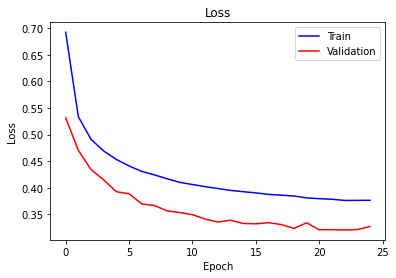

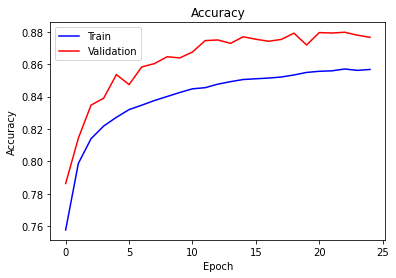

In [ ]:
#Plot the loss and accuracy for the model
plot_history(history_cnn)

In [ ]:
from sklearn.metrics import classification_report

y_val_pred = cnn_model.predict(x_val)
y_val_pred_flat = flatten_pred(y_val_pred)
y_val_flat = flatten_pred(y_val)
print(classification_report(y_val_pred_flat, y_val_flat))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92    106925
           1       0.87      0.87      0.87      5651
           2       0.93      0.91      0.92      7726
           3       0.43      0.85      0.57     10618

    accuracy                           0.88    130920
   macro avg       0.80      0.88      0.82    130920
weighted avg       0.92      0.88      0.89    130920



# LSTM 
Single layer LSTM

In [ ]:
def create_LSTM():
  model = Sequential() 
  model.add(LSTM(100,  activation='relu', return_sequences=True,  input_shape=(40, 6)))
  model.add(Dropout(0.1))
  model.add(Dense(4, activation="softmax"))
  #model.summary()
  model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
lstm_model =create_LSTM()

print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 100)           42800     
_________________________________________________________________
dropout (Dropout)            (None, 40, 100)           0         
_________________________________________________________________
dense (Dense)                (None, 40, 4)             404       
Total params: 43,204
Trainable params: 43,204
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history_lstm = lstm_model.fit(x_train, y_train, epochs=10, verbose=1, validation_data=(x_val, y_val))

Epoch 1/10
921/921 [==============================] - 56s 57ms/step - loss: 1.0211 - accuracy: 0.7480 - val_loss: 0.7006 - val_accuracy: 0.7504
Epoch 2/10
921/921 [==============================] - 53s 57ms/step - loss: 0.6241 - accuracy: 0.7794 - val_loss: 0.5272 - val_accuracy: 0.7979
Epoch 3/10
921/921 [==============================] - 53s 58ms/step - loss: 0.4764 - accuracy: 0.8266 - val_loss: 0.4407 - val_accuracy: 0.8433
Epoch 4/10
921/921 [==============================] - 53s 57ms/step - loss: 0.4269 - accuracy: 0.8444 - val_loss: 0.4142 - val_accuracy: 0.8493
Epoch 5/10
921/921 [==============================] - 52s 56ms/step - loss: 0.3892 - accuracy: 0.8590 - val_loss: 0.3821 - val_accuracy: 0.8607
Epoch 6/10
921/921 [==============================] - 53s 57ms/step - loss: 0.3688 - accuracy: 0.8665 - val_loss: 0.3741 - val_accuracy: 0.8639
Epoch 7/10
921/921 [==============================] - 52s 56ms/step - loss: 0.3546 - accuracy: 0.8720 - val_loss: 0.3579 - val_accuracy:

In [ ]:
history_lstm = lstm_model.fit(x_train, y_train, epochs=15, verbose=1, validation_data=(x_val, y_val))

Epoch 1/15
921/921 [==============================] - 52s 57ms/step - loss: 0.3135 - accuracy: 0.8869 - val_loss: 0.3395 - val_accuracy: 0.8778
Epoch 2/15
921/921 [==============================] - 53s 57ms/step - loss: 0.3032 - accuracy: 0.8910 - val_loss: 0.3450 - val_accuracy: 0.8734
Epoch 3/15
921/921 [==============================] - 53s 57ms/step - loss: 0.2990 - accuracy: 0.8923 - val_loss: 0.3124 - val_accuracy: 0.8866
Epoch 4/15
921/921 [==============================] - 52s 57ms/step - loss: 0.2905 - accuracy: 0.8956 - val_loss: 0.3242 - val_accuracy: 0.8842
Epoch 5/15
921/921 [==============================] - 52s 56ms/step - loss: 0.2845 - accuracy: 0.8971 - val_loss: 0.3077 - val_accuracy: 0.8908
Epoch 6/15
921/921 [==============================] - 52s 56ms/step - loss: 0.2815 - accuracy: 0.8994 - val_loss: 0.3113 - val_accuracy: 0.8876
Epoch 7/15
921/921 [==============================] - 52s 56ms/step - loss: 0.2732 - accuracy: 0.9017 - val_loss: 0.3108 - val_accuracy:

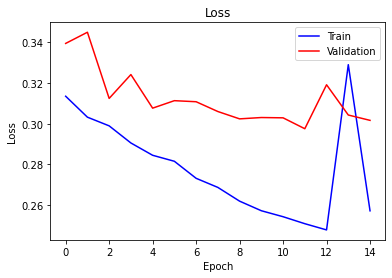

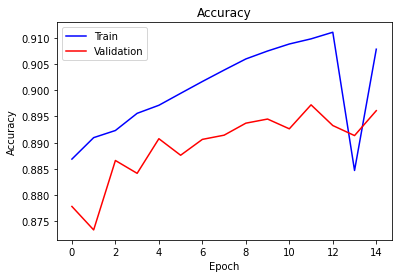

In [ ]:
#Plot the loss and accuracy for the model
plot_history(history_lstm)

In [ ]:
from sklearn.metrics import classification_report

y_val_pred = lstm_model.predict(x_val)
y_val_pred_flat = flatten_pred(y_val_pred)
y_val_flat = flatten_pred(y_val)
print(classification_report(y_val_pred_flat, y_val_flat))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93    104363
           1       0.79      0.90      0.84      4951
           2       0.84      0.91      0.88      6936
           3       0.60      0.86      0.71     14670

    accuracy                           0.90    130920
   macro avg       0.80      0.89      0.84    130920
weighted avg       0.92      0.90      0.90    130920



#BidirectionalLSTM + LSTM
LearningRate-0.01
 Dropout for 1st Layer - 0.2 
 Dropout for 2nd layer - 0.1


In [ ]:
def create_biLSTM():
  model = Sequential()
  model.add(Bidirectional(LSTM(100,return_sequences=True, input_shape=(40,6))))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=True, activation="relu"))
  model.add(Dropout(0.1))
  model.add(Dense(25, activation="relu"))
  model.add(Dense(4, activation="softmax"))
  model.compile(optimizer=Adam(learning_rate=0.01),  loss='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
bilstm_model =create_biLSTM()

history_bilstm = bilstm_model.fit(x_train, y_train, epochs=25, verbose=1, validation_data=(x_val, y_val))

Epoch 1/25
921/921 [==============================] - 95s 65ms/step - loss: 0.6708 - accuracy: 0.7926 - val_loss: 0.3244 - val_accuracy: 0.8788
Epoch 2/25
921/921 [==============================] - 59s 64ms/step - loss: 0.2999 - accuracy: 0.8946 - val_loss: 0.2889 - val_accuracy: 0.9011
Epoch 3/25
921/921 [==============================] - 59s 64ms/step - loss: 0.2411 - accuracy: 0.9169 - val_loss: 0.2600 - val_accuracy: 0.9136
Epoch 4/25
921/921 [==============================] - 58s 63ms/step - loss: 0.2167 - accuracy: 0.9271 - val_loss: 0.2078 - val_accuracy: 0.9288
Epoch 5/25
921/921 [==============================] - 59s 64ms/step - loss: 0.2040 - accuracy: 0.9314 - val_loss: 0.3795 - val_accuracy: 0.8702
Epoch 6/25
921/921 [==============================] - 59s 64ms/step - loss: 0.2776 - accuracy: 0.9061 - val_loss: 0.2421 - val_accuracy: 0.9197
Epoch 7/25
921/921 [==============================] - 59s 64ms/step - loss: 0.2168 - accuracy: 0.9272 - val_loss: 0.2271 - val_accuracy:

In [ ]:
print(bilstm_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 40, 200)           85600     
_________________________________________________________________
dropout_8 (Dropout)          (None, 40, 200)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 40, 50)            50200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 40, 50)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 40, 25)            1275      
_________________________________________________________________
dense_9 (Dense)              (None, 40, 4)             104       
Total params: 137,179
Trainable params: 137,179
Non-trainable params: 0
________________________________________________

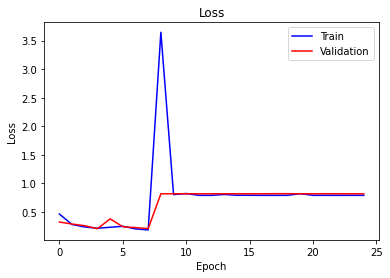

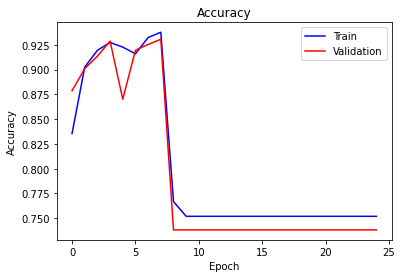

In [ ]:
#Plot the loss and accuracy for the model
plot_history(history_bilstm)

In [ ]:
from sklearn.metrics import classification_report

y_val_pred = lstm_model.predict(x_val)
y_val_pred_flat = flatten_pred(y_val_pred)
y_val_flat = flatten_pred(y_val)
print(classification_report(y_val_pred_flat, y_val_flat, zero_division = 1))

              precision    recall  f1-score   support

           0       1.00      0.74      0.85    130920
           1       0.00      1.00      0.00         0
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0

    accuracy                           0.74    130920
   macro avg       0.25      0.93      0.21    130920
weighted avg       1.00      0.74      0.85    130920



#BidirectionalLSTM + LSTM

LearningRate-0.05
Dropout for 1st Layer - 0.2
Dropout for 2nd layer - 0.1

In [ ]:
def create_LSTM3():
  model = Sequential()
  model.add(Bidirectional(LSTM(100,return_sequences=True, input_shape=(40,6))))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=True, activation="relu"))
  model.add(Dropout(0.1))
  model.add(Dense(25, activation="relu"))
  model.add(Dense(4, activation="softmax"))
  model.compile(optimizer=Adam(learning_rate=0.05),  loss='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
lstm3_model =create_LSTM3()
history_lstm3 = lstm3_model.fit(x_train, y_train, epochs=25, verbose=1, validation_data=(x_val, y_val))

Epoch 1/25
921/921 [==============================] - 94s 64ms/step - loss: 2623594548.8258 - accuracy: 0.7327 - val_loss: 0.8220 - val_accuracy: 0.7381
Epoch 2/25
921/921 [==============================] - 58s 63ms/step - loss: 0.7963 - accuracy: 0.7517 - val_loss: 0.8189 - val_accuracy: 0.7381
Epoch 3/25
921/921 [==============================] - 58s 63ms/step - loss: 0.7925 - accuracy: 0.7535 - val_loss: 0.8196 - val_accuracy: 0.7381
Epoch 4/25
921/921 [==============================] - 58s 63ms/step - loss: 1838.0487 - accuracy: 0.7487 - val_loss: 0.8239 - val_accuracy: 0.7381
Epoch 5/25
921/921 [==============================] - 58s 63ms/step - loss: 0.7965 - accuracy: 0.7540 - val_loss: 0.8191 - val_accuracy: 0.7381
Epoch 6/25
921/921 [==============================] - 58s 63ms/step - loss: 0.8018 - accuracy: 0.7510 - val_loss: 0.8191 - val_accuracy: 0.7381
Epoch 7/25
921/921 [==============================] - 59s 64ms/step - loss: 0.7988 - accuracy: 0.7491 - val_loss: 0.8223 - v

In [ ]:
lstm3_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 40, 200)           85600     
_________________________________________________________________
dropout (Dropout)            (None, 40, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 50)            50200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 50)            0         
_________________________________________________________________
dense (Dense)                (None, 40, 25)            1275      
_________________________________________________________________
dense_1 (Dense)              (None, 40, 4)             104       
Total params: 137,179
Trainable params: 137,179
Non-trainable params: 0
__________________________________________________

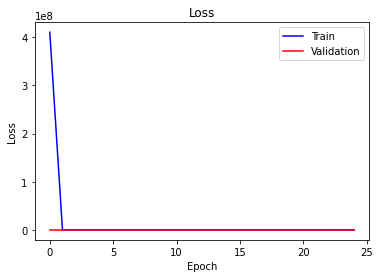

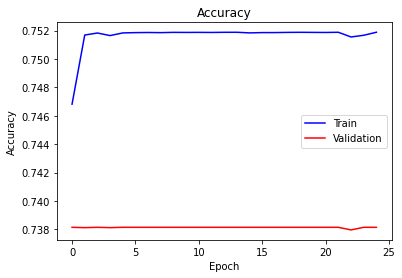

In [ ]:
#Plot the loss and accuracy for the model
plot_history(history_lstm3)

In [ ]:
from sklearn.metrics import classification_report

y_val_pred = lstm3_model.predict(x_val)
y_val_pred_flat = flatten_pred(y_val_pred)
y_val_flat = flatten_pred(y_val)
print(classification_report(y_val_pred_flat, y_val_flat))

              precision    recall  f1-score   support

           0       1.00      0.74      0.85    130920
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.74    130920
   macro avg       0.25      0.18      0.21    130920
weighted avg       1.00      0.74      0.85    130920



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#BidirectionalLSTM + LSTM 
Learning Rate - 0.001
Dropout for 1st Layer - 0.1
Dropout for 2nd layer - 0.1

In [25]:
x_train.shape

(29449, 40, 6)

In [27]:
def create_LSTM_dropout_tuning():
  model = Sequential()
  model.add(Bidirectional(LSTM(100,return_sequences=True, input_shape=(40,6))))
  model.add(Dropout(0.1))
  model.add(LSTM(50, return_sequences=True, activation="relu"))
  model.add(Dropout(0.1))
  model.add(Dense(25, activation="relu"))
  model.add(Dense(4, activation="softmax"))
  model.compile(optimizer=Adam(learning_rate=0.001),  loss='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [30]:

lstm_dropout_tuning =create_LSTM_dropout_tuning()
history_lstm_dropout1 = lstm_dropout_tuning.fit(x_train, y_train, epochs=25, verbose=1, validation_data=(x_val, y_val))

Epoch 1/25
921/921 [==============================] - 66s 67ms/step - loss: 0.6327 - accuracy: 0.7764 - val_loss: 0.3259 - val_accuracy: 0.8859
Epoch 2/25
921/921 [==============================] - 60s 65ms/step - loss: 0.3125 - accuracy: 0.8875 - val_loss: 0.2830 - val_accuracy: 0.9055
Epoch 3/25
921/921 [==============================] - 60s 65ms/step - loss: 0.2626 - accuracy: 0.9116 - val_loss: 0.2331 - val_accuracy: 0.9218
Epoch 4/25
921/921 [==============================] - 59s 64ms/step - loss: 0.2251 - accuracy: 0.9233 - val_loss: 0.2100 - val_accuracy: 0.9310
Epoch 5/25
921/921 [==============================] - 59s 64ms/step - loss: 0.2053 - accuracy: 0.9312 - val_loss: 0.1904 - val_accuracy: 0.9386
Epoch 6/25
921/921 [==============================] - 59s 64ms/step - loss: 0.1863 - accuracy: 0.9364 - val_loss: 0.1813 - val_accuracy: 0.9386
Epoch 7/25
921/921 [==============================] - 60s 65ms/step - loss: 0.1732 - accuracy: 0.9403 - val_loss: 0.2092 - val_accuracy:

In [53]:
lstm_dropout_tuning.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 40, 200)           85600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 40, 200)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 40, 50)            50200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 40, 50)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 40, 25)            1275      
_________________________________________________________________
dense_5 (Dense)              (None, 40, 4)             104       
Total params: 137,179
Trainable params: 137,179
Non-trainable params: 0
________________________________________________

In [35]:
from sklearn.metrics import classification_report

y_val_pred = lstm_dropout_tuning.predict(x_val)
y_val_pred_flat = flatten_pred(y_val_pred)
y_val_flat = flatten_pred(y_val)
print(classification_report(y_val_pred_flat, y_val_flat))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     97193
           1       0.94      0.90      0.92      5877
           2       0.96      0.94      0.95      7604
           3       0.88      0.92      0.90     20246

    accuracy                           0.95    130920
   macro avg       0.94      0.93      0.93    130920
weighted avg       0.96      0.95      0.95    130920



#BidirectionalLSTM +LSTM

Learning Rate - 0.001
Dropout for 1st Layer - 0.2
Dropout for 2nd layer - 0.2


In [ ]:
def create_biLSTM1():
  model = Sequential()
  model.add(Bidirectional(LSTM(100,return_sequences=True, input_shape=(40,6))))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=True, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(25, activation="relu"))
  model.add(Dense(4, activation="softmax"))
  model.compile(optimizer=Adam(learning_rate=0.001),  loss='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
biLSTM1_model =create_biLSTM1()
history_biLSTM1 = biLSTM1_model.fit(x_train, y_train, epochs=25, verbose=1, validation_data=(x_val, y_val))

Epoch 1/25
921/921 [==============================] - 96s 66ms/step - loss: 0.5903 - accuracy: 0.7948 - val_loss: 0.3510 - val_accuracy: 0.8810
Epoch 2/25
921/921 [==============================] - 59s 64ms/step - loss: 0.3254 - accuracy: 0.8819 - val_loss: 0.2757 - val_accuracy: 0.9008
Epoch 3/25
921/921 [==============================] - 59s 64ms/step - loss: 0.2590 - accuracy: 0.9112 - val_loss: 0.2377 - val_accuracy: 0.9227
Epoch 4/25
921/921 [==============================] - 60s 65ms/step - loss: 0.2296 - accuracy: 0.9215 - val_loss: 0.2276 - val_accuracy: 0.9182
Epoch 5/25
921/921 [==============================] - 59s 64ms/step - loss: 0.2103 - accuracy: 0.9282 - val_loss: 0.2099 - val_accuracy: 0.9277
Epoch 6/25
921/921 [==============================] - 59s 64ms/step - loss: 0.1914 - accuracy: 0.9336 - val_loss: 0.1850 - val_accuracy: 0.9361
Epoch 7/25
921/921 [==============================] - 60s 65ms/step - loss: 0.1819 - accuracy: 0.9386 - val_loss: 0.1839 - val_accuracy:

In [ ]:
biLSTM1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 40, 200)           85600     
_________________________________________________________________
dropout (Dropout)            (None, 40, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 50)            50200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 50)            0         
_________________________________________________________________
dense (Dense)                (None, 40, 25)            1275      
_________________________________________________________________
dense_1 (Dense)              (None, 40, 4)             104       
Total params: 137,179
Trainable params: 137,179
Non-trainable params: 0
__________________________________________________

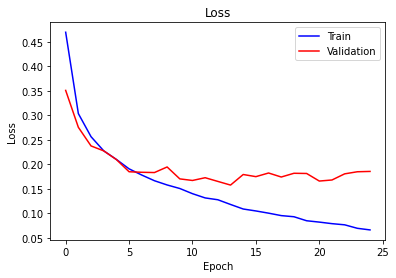

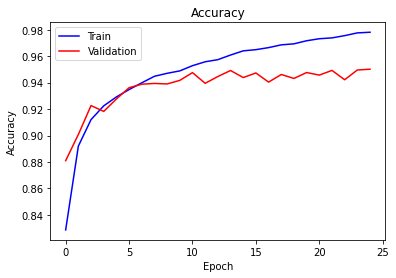

In [ ]:
#Plot the loss and accuracy for the model
plot_history(history_biLSTM1)

In [ ]:
from sklearn.metrics import classification_report

y_val_pred = biLSTM1_model.predict(x_val)
y_val_pred_flat = flatten_pred(y_val_pred)
y_val_flat = flatten_pred(y_val)
print(classification_report(y_val_pred_flat, y_val_flat))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     97633
           1       0.92      0.95      0.93      5511
           2       0.95      0.93      0.94      7653
           3       0.86      0.90      0.88     20123

    accuracy                           0.95    130920
   macro avg       0.92      0.93      0.93    130920
weighted avg       0.95      0.95      0.95    130920



#BidirectionalLSTM + LSTM

Learning Rate - 0.001
Dropout for 1st Layer - 0.2
Dropout for 2nd layer - 0.1

In [16]:
x_train.shape

(29449, 40, 6)

In [17]:
def create_LSTM():
  model = Sequential()
  model.add(Bidirectional(LSTM(100,return_sequences=True, input_shape=(40,6))))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=True, activation="relu"))
  model.add(Dropout(0.1))
  model.add(Dense(25, activation="relu"))
  model.add(Dense(4, activation="softmax"))
  model.compile(optimizer=Adam(learning_rate=0.001),  loss='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [20]:
lstm_model.summary()
lstm_model =create_LSTM()
history_lstm = lstm_model.fit(x_train, y_train, epochs=25, verbose=1, validation_data=(x_val, y_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 40, 200)           85600     
_________________________________________________________________
dropout (Dropout)            (None, 40, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 50)            50200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 50)            0         
_________________________________________________________________
dense (Dense)                (None, 40, 25)            1275      
_________________________________________________________________
dense_1 (Dense)              (None, 40, 4)             104       
Total params: 137,179
Trainable params: 137,179
Non-trainable params: 0
__________________________________________________

## Evaluating performace of the model

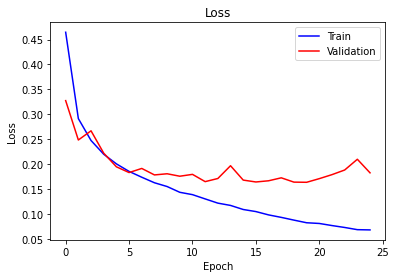

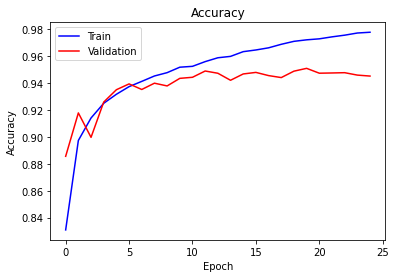

In [21]:
#Plot the loss and accuracy for the model
plot_history(history_lstm)

In [55]:
from sklearn.metrics import classification_report

y_val_pred = lstm_model.predict(x_val)
y_val_pred_flat = flatten_pred(y_val_pred)
y_val_flat = flatten_pred(y_val)
print(classification_report(y_val_pred_flat, y_val_flat))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     96620
           1       0.93      0.92      0.93      5725
           2       0.93      0.95      0.94      7383
           3       0.87      0.87      0.87     21192

    accuracy                           0.95    130920
   macro avg       0.92      0.93      0.93    130920
weighted avg       0.95      0.95      0.95    130920



# Prediction

## Read the test data files

In [22]:
# Read all test data files 
x_test_009 = pd.read_csv('Test_Data_allx/subject_009_01x_meas_time.csv')
x_test_010 = pd.read_csv('Test_Data_allx/subject_010_01x_meas_time.csv')
x_test_011 = pd.read_csv('Test_Data_allx/subject_011_01x_meas_time.csv')
x_test_012 = pd.read_csv('Test_Data_allx/subject_012_01x_meas_time.csv')

x_test_009 = x_test_009.drop('time', axis=1)
x_test_010 = x_test_010.drop('time', axis=1)
x_test_011 = x_test_011.drop('time', axis=1)
x_test_012 = x_test_012.drop('time', axis=1)

## Standardize the Test Data set

Standardize the test data set using .transform function.
We are standardizing the test data set to the same scale to the training dataset.

In [37]:
x_test_009_scaled = scaler.transform(x_test_009)
x_test_009 = pd.DataFrame(x_test_009_scaled, columns = ['ax','ay','az','gx','gy','gz'])

x_test_010_scaled = scaler.transform(x_test_010)
x_test_010 = pd.DataFrame(x_test_010_scaled, columns = ['ax','ay','az','gx','gy','gz'])

x_test_011_scaled = scaler.transform(x_test_011)
x_test_011 = pd.DataFrame(x_test_011_scaled, columns = ['ax','ay','az','gx','gy','gz'])

x_test_012_scaled = scaler.transform(x_test_012)
x_test_012 = pd.DataFrame(x_test_012_scaled, columns = ['ax','ay','az','gx','gy','gz'])

## Creatiing Windows for the test dataset

In [38]:
# Defining Function to Create window for test dataset
def define_test_windows(df_x, windowsize=40):
  window_x=[]
  for i in range(0, len(df_x)-windowsize, windowsize):
    window_x.append([df_x.values[i:i+windowsize]])
  window_x=np.array(window_x).reshape(-1,windowsize,6)
  
  return window_x


In [39]:
#Creating frames for all test subjects
x_09 = define_test_windows(x_test_009, wsize)
x_10 = define_test_windows(x_test_010, wsize)
x_11 = define_test_windows(x_test_011, wsize)
x_12 = define_test_windows(x_test_012, wsize)

In [40]:
x_09.shape

(949, 40, 6)

## Perform prediction and transform the predicted categorical values to integer labels

In [41]:
def predictions(model):
  y_pred_009 = model.predict(x_09)
  y_pred_010 = model.predict(x_10)
  y_pred_011 = model.predict(x_11)
  y_pred_012 = model.predict(x_12)

  #prediction for Subject 09
  y_009 = y_pred_009.tolist()
  yhat_009 = flatten_pred(y_009)

  #prediction for Subject 10
  y_010 = y_pred_010.tolist()
  yhat_010 = flatten_pred(y_010)

  #prediction for Subject 11
  y_011 = y_pred_011.tolist()
  yhat_011 = flatten_pred(y_011)

  #prediction for Subject 12
  y_012 = y_pred_012.tolist()
  yhat_012 = flatten_pred(y_012)

  print(y_pred_009.shape, y_pred_010.shape, y_pred_011.shape, y_pred_012.shape)

  return yhat_009, yhat_010, yhat_011, yhat_012

In [42]:
#Predictions for all test subjects
yhat_009, yhat_010, yhat_011, yhat_012 = predictions(lstm_model)

(949, 40, 4) (1227, 40, 4) (1294, 40, 4) (1132, 40, 4)


In [43]:
yhat_009_df=pd.DataFrame(yhat_009, columns=['label'])
yhat_010_df=pd.DataFrame(yhat_010, columns=['label'])
yhat_011_df=pd.DataFrame(yhat_011, columns=['label'])
yhat_012_df=pd.DataFrame(yhat_012, columns=['label'])

In [44]:
# Read all test data files 
x_meas9 = pd.read_csv('Test_Data_allx/subject_009_01x_meas_time.csv')
x_meas10 = pd.read_csv('Test_Data_allx/subject_010_01x_meas_time.csv')
x_meas11 = pd.read_csv('Test_Data_allx/subject_011_01x_meas_time.csv')
x_meas12 = pd.read_csv('Test_Data_allx/subject_012_01x_meas_time.csv')

In [45]:
x_meas9 = x_meas9.join(yhat_009_df, how='left')
x_meas10 = x_meas10.join(yhat_010_df, how='left')
x_meas11 = x_meas11.join(yhat_011_df, how='left')
x_meas12 = x_meas12.join(yhat_012_df, how='left')

x_meas9['label'] = x_meas9['label'].fillna(0)
x_meas10['label'] = x_meas10['label'].fillna(0)
x_meas11['label'] = x_meas11['label'].fillna(0)
x_meas12['label'] = x_meas12['label'].fillna(0)

In [46]:
y_time_009 = pd.read_csv('Test_Data_allx/subject_009_01y_time.csv')
y_time_010 = pd.read_csv('Test_Data_allx/subject_010_01y_time.csv')
y_time_011 = pd.read_csv('Test_Data_allx/subject_011_01y_time.csv')
y_time_012 = pd.read_csv('Test_Data_allx/subject_012_01y_time.csv')

In [47]:
xmeasfinal9 = pd.merge(x_meas9, y_time_009, on='time', how='inner')
xmeasfinal10 = pd.merge(x_meas10, y_time_010, on='time', how='inner')
xmeasfinal11 = pd.merge(x_meas11, y_time_011, on='time', how='inner')
xmeasfinal12 = pd.merge(x_meas12, y_time_012, on='time', how='inner')

In [ ]:
# Change the test result directory before running this cell
xmeasfinal9['label'].to_csv("TestResults/new/tuning/subject_009_01__y_prediction.csv", index=False, header=False)
xmeasfinal10['label'].to_csv("TestResults/new/tuning/subject_010_01__y_prediction.csv", index=False, header=False)
xmeasfinal11['label'].to_csv("TestResults/new/tuning/subject_011_01__y_prediction.csv", index=False, header=False)
xmeasfinal12['label'].to_csv("TestResults/new/tuning/subject_012_01__y_prediction.csv", index=False, header=False)

#Illustration of Test dataset

Taking the labels of subject 9 and checking the labels and identifying the prediction pattern

In [38]:
x_measfinal9 = pd.read_csv('TestResults/new/subject_009_01__y_prediction.csv')
x_measfinal10 = pd.read_csv('TestResults/new/subject_010_01__y_prediction.csv')
x_measfinal11 = pd.read_csv('TestResults/new/subject_011_01__y_prediction.csv')
x_measfinal12 = pd.read_csv('TestResults/new/subject_012_01__y_prediction.csv')
print(x_measfinal9.value_counts())
print(x_measfinal10.value_counts())
print(x_measfinal11.value_counts())
print(x_measfinal12.value_counts())

0.0
0.0    8586
3.0     422
1.0     340
2.0     149
dtype: int64
0.0
0.0    8007
3.0    3348
2.0     467
1.0     447
dtype: int64
0.0
0.0    8979
3.0    2747
2.0     738
1.0     475
dtype: int64
0.0
0.0    8869
3.0     988
2.0     852
1.0     620
dtype: int64


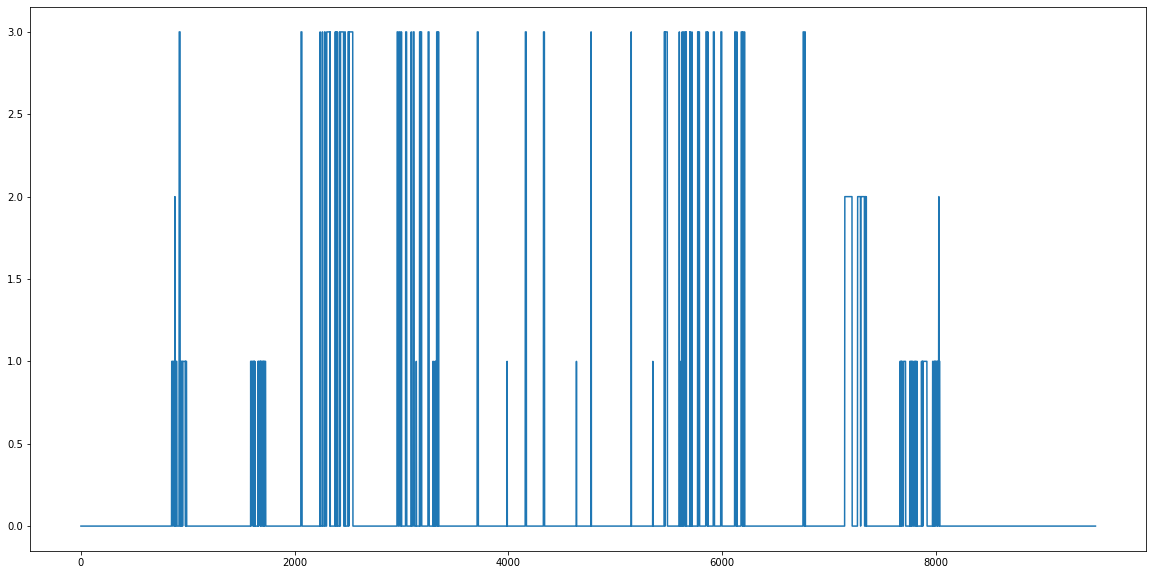

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(x_measfinal9)
plt.show()

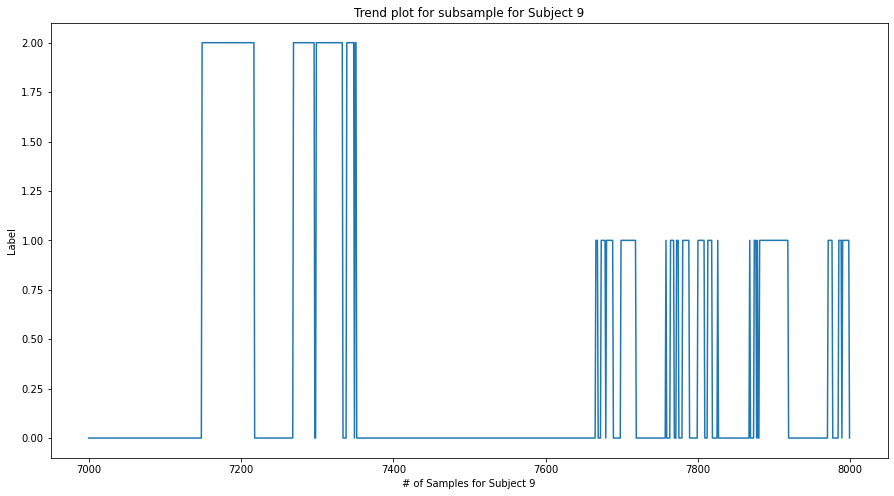

In [36]:
plt.figure(figsize=(15, 8))
plt.plot(x_measfinal9[7000:8000])
plt.ylabel('Label')
plt.xlabel('# of Samples for Subject 9')
plt.title('Trend plot for subsample for Subject 9')
plt.show()